In [1]:
import torch
import torch.nn as nn
import numpy as np
from torch.autograd import Variable
import time
USE_GPU = True
from model import *
from data_loaders import load_mnist
from tools import weights_init_xavier
from stats import Statistics
import matplotlib.pyplot as plt
import os.path as path
SAVE_DIR = "saved_models"
FILENAME = "modelk.pt"

In [2]:
def initialize_weights(capsnet):
  capsnet.conv_layer.conv.apply(weights_init_xavier)
  capsnet.primary_capsules.apply(weights_init_xavier)
  capsnet.decoder.apply(weights_init_xavier)
  #nn.init.xavier_normal_(capsnet.digit_caps.W)

In [3]:
capsnet = CapsNet(reconstruction_type="FC") # FC or Conv
if USE_GPU:
  capsnet.cuda()
optimizer = torch.optim.Adam(capsnet.parameters())

In [4]:
filepath = path.join(SAVE_DIR, FILENAME)
if path.isfile(filepath):
  print("Saved model found")
  capsnet.load_state_dict(torch.load(filepath))
else:
  print("Saved model not found; Model initialized.")
  initialize_weights(capsnet)

Saved model not found; Model initialized.


In [5]:
"""Hyperparameters"""
max_epochs = 1000
batch_size = 128
train_loader, test_loader = load_mnist(batch_size)
stats = Statistics()

In [ ]:

display_step = 450

for epoch in range(max_epochs):
  capsnet.train()
  for batch, (data, target) in list(enumerate(train_loader)):
    target = torch.eye(10).index_select(dim=0, index=target)
    data, target = Variable(data), Variable(target)
    if USE_GPU:
      data, target = data.cuda(), target.cuda()
    
    optimizer.zero_grad()
    
    output, reconstructions, masked = capsnet(data, target)
    data = data - data.min()
    data = data / data.max() 
    loss, rec_loss = capsnet.loss(data, target, output, reconstructions)
    
    loss.backward()
    optimizer.step()
    
    stats.track_train(loss.data.item(), rec_loss.data.item())
    
    if batch % display_step == 0 and batch != 0:
      capsnet.eval()

      for batch_id, (data, target) in enumerate(test_loader):
        target = torch.eye(10).index_select(dim=0, index=target)
        data, target = Variable(data), Variable(target)
        if USE_GPU:
          data,target = data.cuda(), target.cuda()

        output, reconstructions, masked = capsnet(data)
        loss, rec_loss = capsnet.loss(data, target, output, reconstructions)
        
        stats.track_test(loss.data.item(),rec_loss target, masked)
        
      stats.save_stats(epoch)

      filepath = path.join(SAVE_DIR, "model{}.pt".format(epoch))
      torch.save(capsnet.state_dict(), filepath)
      capsnet.train()
  

Epoch:   0 	 Time: 141 	 Test: 0.015 	 Train: 0.002 	 Accuracy: 99.4600 Reconstruction: 0.0496
Epoch:   1 	 Time: 105 	 Test: 0.015 	 Train: 0.002 	 Accuracy: 99.5600 Reconstruction: 0.0495
Epoch:   2 	 Time: 104 	 Test: 0.015 	 Train: 0.002 	 Accuracy: 99.5000 Reconstruction: 0.0495
Epoch:   3 	 Time: 105 	 Test: 0.015 	 Train: 0.001 	 Accuracy: 99.4800 Reconstruction: 0.0495


In [26]:
capsnet.eval()
data, target = iter(test_loader).next()
output, reconstruction, masked = capsnet(data.cuda())

In [27]:
predictions = torch.max((output**2).sum(dim=2).squeeze(), dim=1)[1].cpu().data.numpy()

tensor(3) 3


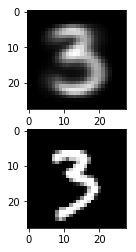

In [33]:
i = 30
print(target[i], predictions[i])
im = reconstruction[i,0].data.cpu().numpy()
plt.subplot(2,1,1)
plt.imshow(im, cmap="gray")
im2 = data[i, 0].data.cpu().numpy()
im2 += abs(im.min())
im2 /= im.max()
plt.subplot(2,1,2)
plt.imshow(im2, cmap="gray")

In [ ]:
stats.RECONSTRUCTION_LOSS